In [20]:
import pandas as pd
import numpy as np

#gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import wordnet
import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [21]:
st_df = pd.read_pickle('../data/st_trails_df_2')
st_df_with_desc = st_df[st_df['description_length']>=40]
X = st_df_with_desc['description']
documents = X

In [22]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

not_stops_firstpass = ['not', 'bottom', 'few', 'many', 'more', 'less', 'most', 'least', 'never', 'off', 'out'\
                           'very', 'too', 'overly', 'so']
new_stops_firstpass = ['br']
first_stopwords = (STOPWORDS.difference(not_stops_firstpass)).union(new_stops_firstpass)

In [23]:
def tokenize(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(token)
    return result

def remove_stopwords_firstpass(tokenized_text):
    result = []
    for word in tokenized_text:
        if word not in first_stopwords:
            result.append(word)
    return result

tokenized_docs = documents.map(tokenize)
tokenized_docs[:10]
tokenized_nostops = tokenized_docs.map(remove_stopwords_firstpass)
tokenized_nostops[:10]

0    [mcdonald, dunn, forest, offers, incredible, v...
1    [ride, north, left, intersection, run, creeks,...
2    [trail, starts, far, bridge, parking, lot, goe...
3    [description, description, north, south, trail...
4    [rides, hardy, creek, trail, head, deerskull, ...
5    [good, ride, beginer, mt, cross, bike, good, s...
6    [miles, lava, field, making, toughest, picnic,...
7    [blackrock, mountain, bike, trail, wooden, dir...
8    [trailhead, right, campground, outhouse, trail...
9    [recomend, noth, ridge, good, hill, careful, c...
Name: description, dtype: object

In [24]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

sent_stream = tokenized_nostops

bigram = Phrases(sent_stream, min_count=5, threshold=2)
# bigram.export_phrases(sent_stream)
bigram_phraser = Phraser(bigram)

def bigramize(text):
    return bigram_phraser[text]

bigrams = tokenized_nostops.map(bigramize)
trigram = Phrases(bigrams, min_count=5, threshold=2)
trigram_phraser = Phraser(trigram)

def trigramize(text):
    return trigram_phraser[text]

trigrams = bigrams.map(trigramize)
type(trigrams[0])

list

In [25]:
my_stopwords = set(['climb', 'mountain', 'road', 'singletrack', 'loop', 'trail', 'trails',  'ride', 'area', 'route', 'way', \
                    'feature', 'section','sections', 'riding', \
                'loop','br', 'mile', 'miles', 'right', 'left', 'www', 'http', 'https', 'bike', 'bikes', 'bicycle', 'bicycles', \
                'continue', 'rider', 'riders', 'parking', 'lot', 'turn', 'start', 'starts', 'description', 'cross', \
                'north', 'south', 'east', 'west', '-PRON-', 'pron', 'nee', 'regard', 'shall', 'use', 'win', \
                   'park', 'point', 'biking', 'follow', 'single', 'track', 'intersection', 'trailhead', 'head', \
                   'good', 'great', 'nice', 'time', 'include', 'place', 'come', 'downhill', 'look', 'near'])
bitri_stops = set(['parking_lot', 'trail_starts', 'mile_turn', 'north_south', 'mountain_bike', 'mountain_biking', 'single_track', \
                  'mountain_bike_trail', 'trail_head'])
all_stopwords = my_stopwords.union(STOPWORDS).union(bitri_stops)

In [26]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {'j': 'a',
            'n': 'n',
            'v': 'v',
            'r': 'r'}
    return tag_dict.get(tag, 'n')


def lemmatize_(text):
    pos = get_wordnet_pos(text)
    return WordNetLemmatizer().lemmatize(text, pos=pos)

def preprocess(text):
    result = []
    for token in text:
        if (token not in all_stopwords) and (len(token) > 3):
            lem = lemmatize_(token)
            if lem not in all_stopwords:
                result.append(lem)
    return result

In [27]:
processed_docs = trigrams.map(preprocess)

In [28]:
processed_docs[3]

['saddle',
 'forest',
 'limited',
 'view',
 'ridge',
 'wonderful',
 'view',
 'trail_follows',
 'ridge',
 'line',
 'base',
 'sunrise',
 'peak',
 'drop',
 'meadow',
 'pond',
 'ridge',
 'skirt',
 'juniper',
 'peak',
 'sunrise',
 'peak',
 'jumbo',
 'peak',
 'trail_ends',
 'dark',
 'meadow',
 'boundary',
 'improvement',
 'plan',
 'check',
 'randle',
 'district',
 'current',
 'information',
 'open',
 'ridgetop',
 'burn',
 'result',
 'beautiful',
 'meadow',
 'ridge',
 'today',
 'more_difficult',
 'sheepherder',
 'stock',
 'driveway',
 'water',
 'trough',
 'jumbo',
 'peak',
 'motorize']

In [29]:
#create dictionary
id2word = gensim.corpora.Dictionary(processed_docs)
id2word.filter_extremes(no_below=3, no_above=0.6, keep_n=10000, keep_tokens=None)

#create corpus
texts = processed_docs 

#Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [51]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2)

In [53]:
from pprint import pprint

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.010*"ridge" + 0.008*"technical" + 0.008*"hill" + 0.007*"pas" + '
  '0.007*"rock" + 0.007*"creek" + 0.006*"like" + 0.006*"small" + 0.006*"jump" '
  '+ 0.005*"couple"'),
 (1,
  '0.016*"hill" + 0.014*"little" + 0.007*"sign" + 0.006*"built" + '
  '0.006*"ridge" + 0.006*"easy" + 0.006*"line" + 0.006*"river" + '
  '0.006*"valley" + 0.006*"rock"'),
 (2,
  '0.010*"hill" + 0.008*"rock" + 0.008*"steep" + 0.007*"long" + 0.006*"lake" + '
  '0.006*"challenge" + 0.006*"couple" + 0.006*"hiker" + 0.006*"valley" + '
  '0.006*"ridge"'),
 (3,
  '0.018*"river" + 0.010*"switchbacks" + 0.007*"foot" + 0.007*"rock" + '
  '0.007*"easy" + 0.007*"ridge" + 0.006*"drop" + 0.006*"access" + 0.006*"hill" '
  '+ 0.006*"bridge"'),
 (4,
  '0.012*"lake" + 0.012*"technical" + 0.008*"view" + 0.008*"ridge" + '
  '0.007*"direction" + 0.006*"sure" + 0.006*"creek" + 0.006*"doubletrack" + '
  '0.006*"sign" + 0.006*"easy"'),
 (5,
  '0.020*"creek" + 0.008*"rock" + 0.008*"lake" + 0.006*"forest" + 0.006*"fast" '
  '+ 0.00

In [45]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.3509001565009084

Coherence Score:  0.3466495949197344


In [33]:
# Trying out different values for number of topics
num_topics = np.arange(2, 20, 2)

perplexities = []
coherences = []

for k in num_topics:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k, id2word=id2word, passes=2, workers=2)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

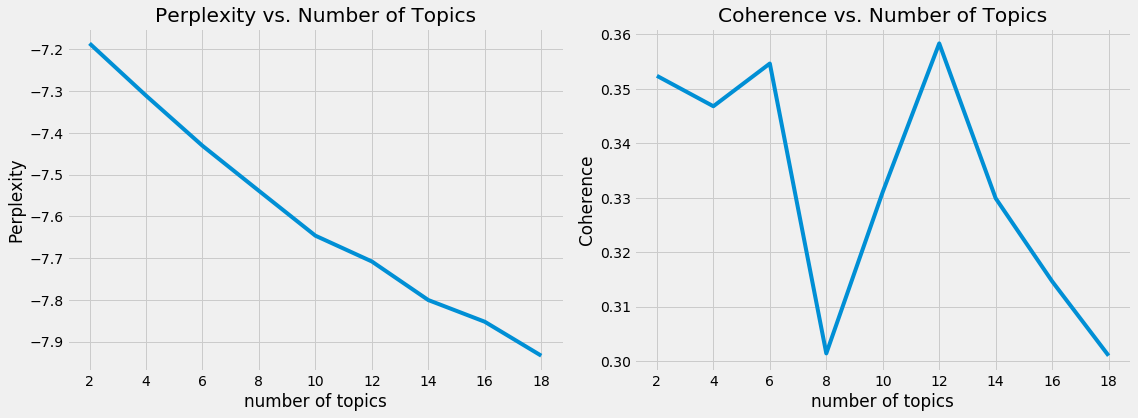

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(num_topics, perplexities)
axs[0].set_xlabel('number of topics')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Number of Topics')
axs[1].plot(num_topics, coherences)
axs[1].set_xlabel('number of topics')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Number of Topics')
fig.tight_layout(pad=1)
fig.savefig('../images/st_lda_metrics_topics.png')

In [38]:
# Trying out different values for alpha (document-topic-prior)
alphas = np.arange(0.1, 1.1, 0.1)

perplexities = []
coherences = []

for a in alphas:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2, alpha=a)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

Text(0.5,1,'Coherence vs. Alpha')

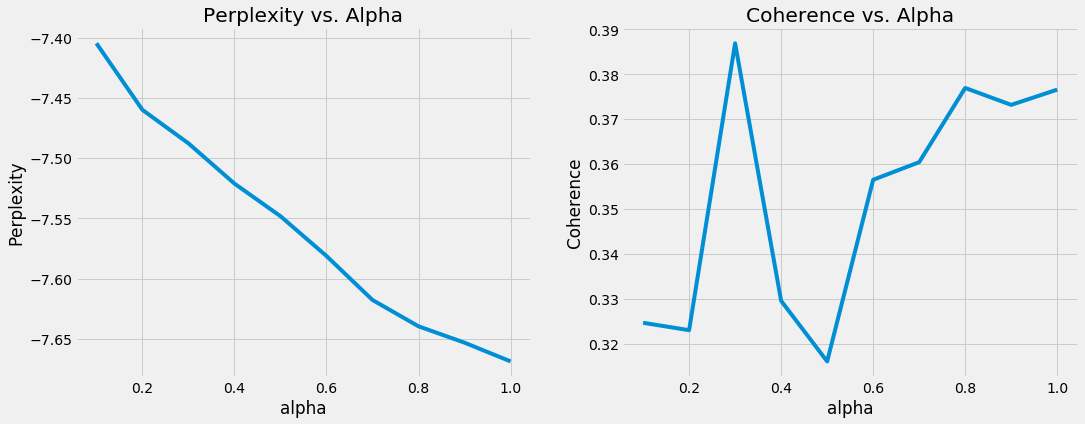

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(alphas, perplexities)
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Alpha')
axs[1].plot(alphas, coherences)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Alpha')


In [40]:
# Trying out different values for eta (topic-word-prior)
etas = np.arange(0, 1, 0.1)

perplexities = []
coherences = []

for e in etas:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2, alpha=0.6, eta=e)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:1116: RuntimeWarning: invalid value encountered in double_scalars
  score += np.sum(gammaln(sum_eta) - gammaln(np.sum(_lambda, 1)))


Text(0.5,1,'Coherence vs. Eta')

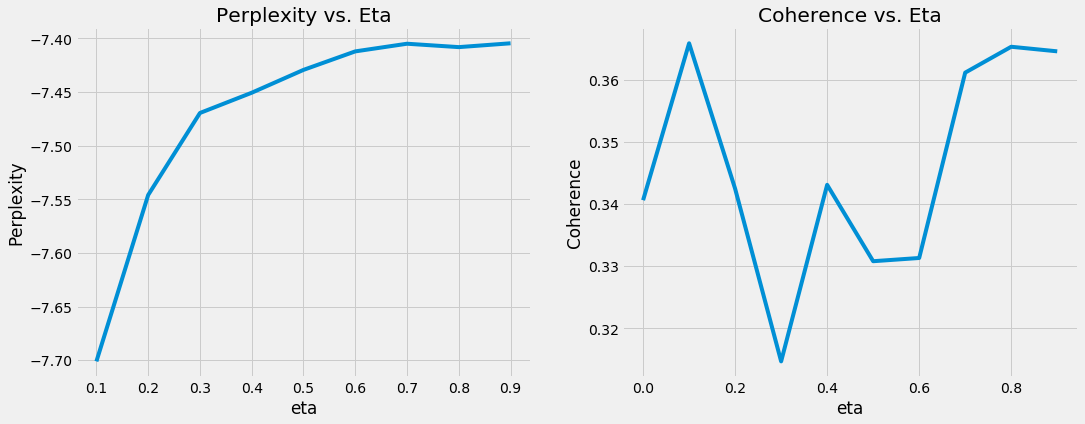

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(etas, perplexities)
axs[0].set_xlabel('eta')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Eta')
axs[1].plot(etas, coherences)
axs[1].set_xlabel('eta')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Eta')


In [46]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=10, workers=2)

In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.008172  0.024450       1        1  32.850285
0      0.023669  0.005058       2        1  18.137655
5     -0.128772 -0.030657       3        1  15.632176
3      0.078974  0.031749       4        1  11.811518
4     -0.021987  0.089648       5        1  11.327197
2      0.039946 -0.120248       6        1  10.241179, topic_info=    Category        Freq    Term       Total  loglift  logprob
44   Default  171.000000   creek  171.000000  30.0000  30.0000
433  Default  144.000000    lake  144.000000  29.0000  29.0000
79   Default  114.000000  little  114.000000  28.0000  28.0000
338  Default  147.000000    rock  147.000000  27.0000  27.0000
32   Default  109.000000   river  109.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
362   Topic6    8.536031    wide   44.422924   0.6293  -5.6063
87    Topic6    8.623951    past   62.735104   0.2944  -5.5961
237   Topic6    8.447082  pretty   59.492035   0.3267  -5.6168
361   Topic6    8.164762   watch   49.997284   0.4666  -5.6508
433   Topic6    8.283088    lake  144.950058  -0.5834  -5.6364

[438 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1191      1  0.884303  absolutely
391       1  0.401760      access
391       2  0.057394      access
391       3  0.215228      access
391       4  0.172183      access
...     ...       ...         ...
423       3  0.021638        work
423       4  0.151466        work
423       5  0.216381        work
423       6  0.151466        work
863       1  0.882063        zone

[1046 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 4, 5, 3])